In [179]:
from __future__ import print_function,division,absolute_import
import tables
import numpy as np
from keras.utils import to_categorical
from keras.models import model_from_json
from custom_layers import Conv1D_linearphase, DCT1D
from heartnet_v1 import reshape_folds
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [276]:
log_name = 'fold1+compare 2018-04-17 22:03:55.445492'
checkpoint_name = "/media/taufiq/Data1/heart_sound/models/fold1+compare 2018-05-05 17:04:36.995687/weights.0007-0.8148.hdf5"
min_epoch = 100
min_metric = .7
confidence_thresh = 0.2

foldname = 'fold1+compare'
fold_dir = '/media/taufiq/Data1/heart_sound/feature/segmented_noFIR/'
model_dir = '/media/taufiq/Data1/heart_sound/models/'
log_dir = '/media/taufiq/Data1/heart_sound/logs/'

## Load Model from checkpoint

In [ ]:
model_dir = checkpoint_name[:checkpoint_name.find('fold')]
log_name = checkpoint_name[checkpoint_name.find('fold'):checkpoint_name.find('weights')-1]
print(log_name)

In [ ]:
if os.path.isdir(model_dir+log_name):
    print("Model directory found")
    if os.path.isfile(os.path.join(model_dir+log_name,"model.json")):
        print("model.json found. Importing")
    else:
        raise ImportError("model.json not found")

In [ ]:
with open(os.path.join(model_dir+log_name,"model.json")) as json_file:
    loaded_model_json = json_file.read()
model = model_from_json(loaded_model_json,{'Conv1D_linearphase':Conv1D_linearphase,'DCT1D':DCT1D})
model.load_weights(checkpoint_name)

## Load Data

In [162]:
############## Importing data ############
feat = tables.open_file(fold_dir + foldname + '.mat')
x_train = feat.root.trainX[:]
y_train = feat.root.trainY[0, :]
x_val = feat.root.valX[:]
y_val = feat.root.valY[0, :]
train_parts = feat.root.train_parts[0, :]
val_parts = feat.root.val_parts[0, :]

############## Relabeling ################

for i in range(0, y_train.shape[0]):
    if y_train[i] == -1:
        y_train[i] = 0  ## Label 0 for normal 1 for abnormal
for i in range(0, y_val.shape[0]):
    if y_val[i] == -1:
        y_val[i] = 0

############# Parse Database names ########

train_files = []
for each in feat.root.train_files[:][0]:
    train_files.append(chr(each))
print(len(train_files))
val_files = []
for each in feat.root.val_files[:][0]:
    val_files.append(chr(each))
print(len(val_files))

################### Reshaping ############

x_train, y_train, x_val, y_val = reshape_folds(x_train, x_val, y_train, y_val)
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)

3283
515
(93942, 2500, 1)
(93942, 1)
(15511, 2500, 1)
(15511, 1)


## Load Training and Validation Filenames

In [68]:
import matlab.engine
eng = matlab.engine.start_matlab()
fold1_filenames = eng.load(os.path.join(fold_dir,'fold1_filenames.mat'))
compare_filenames = eng.load(os.path.join(fold_dir,'compare_filenames.mat'))
eng.quit()

train_filenames = fold1_filenames['train_files']
train_filenames.extend(compare_filenames['train_files'])
val_filenames = fold1_filenames['val_files']
val_filenames.extend(compare_filenames['val_files'])
print("Filenames Loaded : Train files {} and Validation Files {}".format(len(train_filenames),len(val_filenames)))

Filenames Loaded : Train files 3283 and Validation Files 515


In [81]:
dfTrain = pd.DataFrame(train_filenames,columns={"filenames"})
dfVal = pd.DataFrame(val_filenames,columns={"filenames"})
dfTrain['dataset'] = train_files
dfVal['dataset'] = val_files
dfVal.head()

,filenames,dataset
0,a0156.wav,a
1,a0148.wav,a
2,a0099.wav,a
3,b0265.wav,b
4,b0319.wav,b


## Get true labels per recording and append 

In [183]:
true = []
start_idx = 0
y_val_cc = np.transpose(np.argmax(y_val, axis=-1))
for s in val_parts:
    if not s:  ## for e00032 in validation0 there was no cardiac cycle
        continue
    # ~ print "part {} start {} stop {}".format(s,star_idx,start_idx+int(s)-1)
    temp_ = y_val_cc[start_idx:start_idx + int(s) - 1]
    if (sum(temp_ == 0) > sum(temp_ == 1)):
        true.append(0)
    else:
        true.append(1)
    start_idx = start_idx + int(s)
dfVal['true'] = true

true = []
start_idx = 0
y_train_cc = np.transpose(np.argmax(y_train, axis=-1))
for s in train_parts:
    if not s:  ## for e00032 in validation0 there was no cardiac cycle
        continue
    # ~ print "part {} start {} stop {}".format(s,start_idx,start_idx+int(s)-1)
    temp_ = y_train_cc[start_idx:start_idx + int(s) - 1]
    if (sum(temp_ == 0) > sum(temp_ == 1)):
        true.append(0)
    else:
        true.append(1)
    start_idx = start_idx + int(s)
dfTrain['true'] = true

## Load Model from log name


Given a log_name it scans through the directories and finds the best three weights considering Sensitivity, Specificity and Macc.

In [211]:
if os.path.isdir(model_dir+log_name):
    print("Model directory found")
    if os.path.isfile(os.path.join(model_dir+log_name,"model.json")):
        print("model.json found. Importing")
    else:
        raise ImportError("model.json not found")

with open(os.path.join(model_dir+log_name,"model.json")) as json_file:
    loaded_model_json = json_file.read()
model = model_from_json(loaded_model_json,{'Conv1D_linearphase':Conv1D_linearphase,'DCT1D':DCT1D})
model.summary()

Model directory found
model.json found. Importing
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2500, 1)      0                                            
__________________________________________________________________________________________________
conv1d_linearphase_1 (Conv1D_li (None, 2500, 1)      31          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_linearphase_2 (Conv1D_li (None, 2500, 1)      31          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_linearphase_3 (Conv1D_li (None, 2500, 1)      31          input_1[0][0]                    
___________________________________________________________

In [216]:
training_csv = os.path.join(log_dir+log_name,"training.csv")
df = pd.read_csv(training_csv)

In [293]:
sens_idx = df['val_sensitivity'][df.epoch>min_epoch][df.val_specificity>min_metric].idxmax()
spec_idx = df['val_specificity'][df.epoch>min_epoch][df.val_sensitivity>min_metric].idxmax()
macc_idx = df['val_macc'][df.epoch>min_epoch].idxmax()
val_idx = df['val_acc'][df.epoch>min_epoch].idxmax()


In [340]:
weights = dict()
weights['val_sensitivity'] = "weights.%.4d-%.4f.hdf5" % (df.epoch.iloc[sens_idx]+1,df.val_acc.iloc[sens_idx])
weights['val_specificity'] = "weights.%.4d-%.4f.hdf5" % (df.epoch.iloc[spec_idx]+1,df.val_acc.iloc[spec_idx])
weights['val_macc'] = "weights.%.4d-%.4f.hdf5" % (df.epoch.iloc[macc_idx]+1,df.val_acc.iloc[macc_idx])
weights['val_acc'] = "weights.%.4d-%.4f.hdf5" % (df.epoch.iloc[val_idx]+1,df.val_acc.iloc[val_idx])
print("Best Sensitivity model: {} \t\t{}".format(df.val_sensitivity.iloc[sens_idx],weights['val_sensitivity']))
print("Best Specificity model: {} \t\t{}".format(df.val_specificity.iloc[spec_idx],weights['val_specificity']))
print("Best Macc model: {} \t\t{}".format(df.val_macc.iloc[macc_idx],weights['val_macc']))
print("Best Val model: {} \t\t\t{}".format(df.val_acc.iloc[val_idx],weights['val_acc']))

Best Sensitivity model: 0.926282018625 		weights.0113-0.8270.hdf5
Best Specificity model: 0.81280783773 		weights.0127-0.7633.hdf5
Best Macc model: 0.825920451026 		weights.0142-0.8053.hdf5
Best Val model: 0.83624524541 			weights.0161-0.8362.hdf5


In [365]:
metric = 'val_specificity'
checkpoint_name = os.path.join(model_dir+log_name,weights[metric])
model.load_weights(checkpoint_name)
print("Checkpoint loaded:\n %s" % checkpoint_name)

Checkpoint loaded:
 /media/taufiq/Data1/heart_sound/models/fold1+compare 2018-04-17 22:03:55.445492/weights.0127-0.7633.hdf5


## Get Validation Predictions, get per recording Confidence and append

In [366]:
y_pred = model.predict(x_val, verbose=1)
y_pred_hard = np.argmax(y_pred,axis=-1)


15511/15511 [==============================] - 2s 105us/step


#### Find predicted confidence of cardiac cycles for the true labels

In [367]:
predicted_confidence = np.asarray([y_pred[i,j] for i,j in zip(range(len(y_pred)),np.nditer(y_val_cc))]) 

#### Calculate percentage confidence for true labels per recording

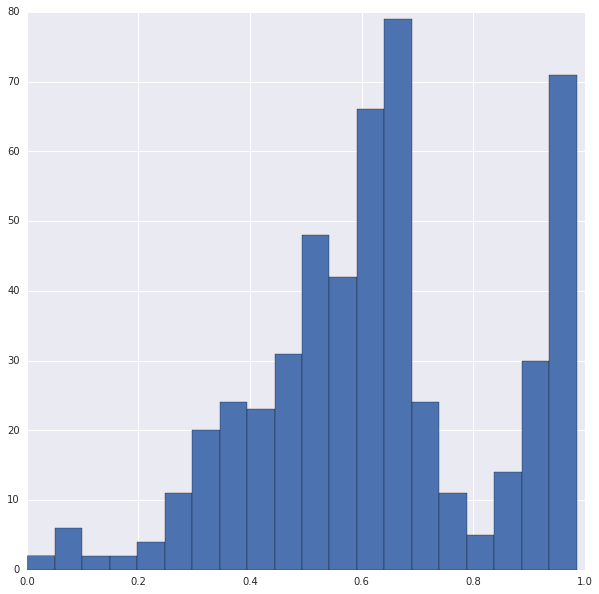

In [368]:
start_idx=0
pred = []
for s in val_parts:
    if not s:  ## for e00032 in validation0 there was no cardiac cycle
        continue
    # ~ print "part {} start {} stop {}".format(s,star_idx,start_idx+int(s)-1)
    temp = sum(predicted_confidence[start_idx:start_idx + int(s) - 1])/s
    pred.append(temp)
    start_idx = start_idx + int(s)
dfVal['conf_'+metric]=pred
plt.figure(figsize=(10,10))
dfVal['conf_'+metric].hist(bins=20)
plt.show()

## Get Training Predictions, get per recording Confidence and append

93942/93942 [==============================] - 11s 119us/step


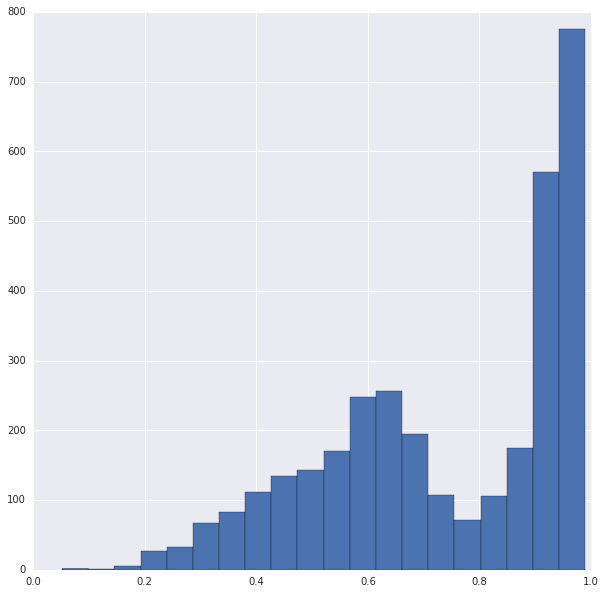

In [369]:
y_pred = model.predict(x_train, verbose=1)
y_pred_hard = np.argmax(y_pred,axis=-1)
predicted_confidence = np.asarray([y_pred[i,j] for i,j in zip(range(len(y_pred)),np.nditer(y_train_cc))])
start_idx=0
pred = []
for s in train_parts:
    if not s:  ## for e00032 in validation0 there was no cardiac cycle
        continue
    # ~ print "part {} start {} stop {}".format(s,star_idx,start_idx+int(s)-1)
    temp = sum(predicted_confidence[start_idx:start_idx + int(s) - 1])/s
    pred.append(temp)
    start_idx = start_idx + int(s)
dfTrain['conf_'+metric]=pred
plt.figure(figsize=(10,10))
dfTrain['conf_'+metric].hist(bins=20)
plt.show()

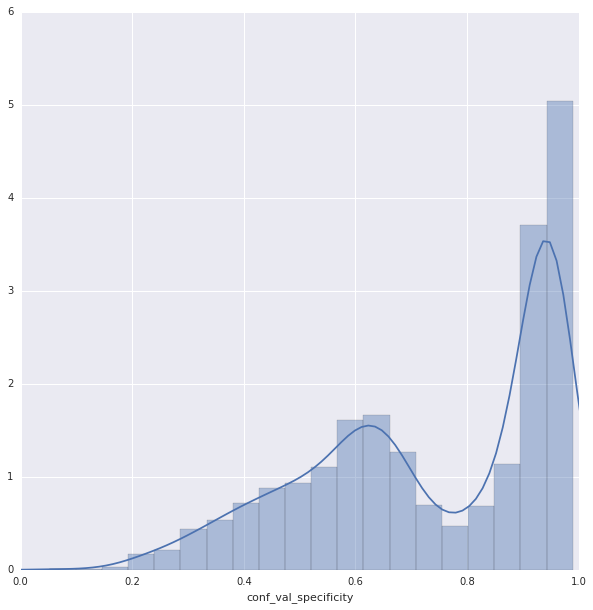

In [371]:
plt.figure(figsize=(10,10))
sns.distplot(dfTrain['conf_'+metric])
plt.xlim(0,1)
plt.show()

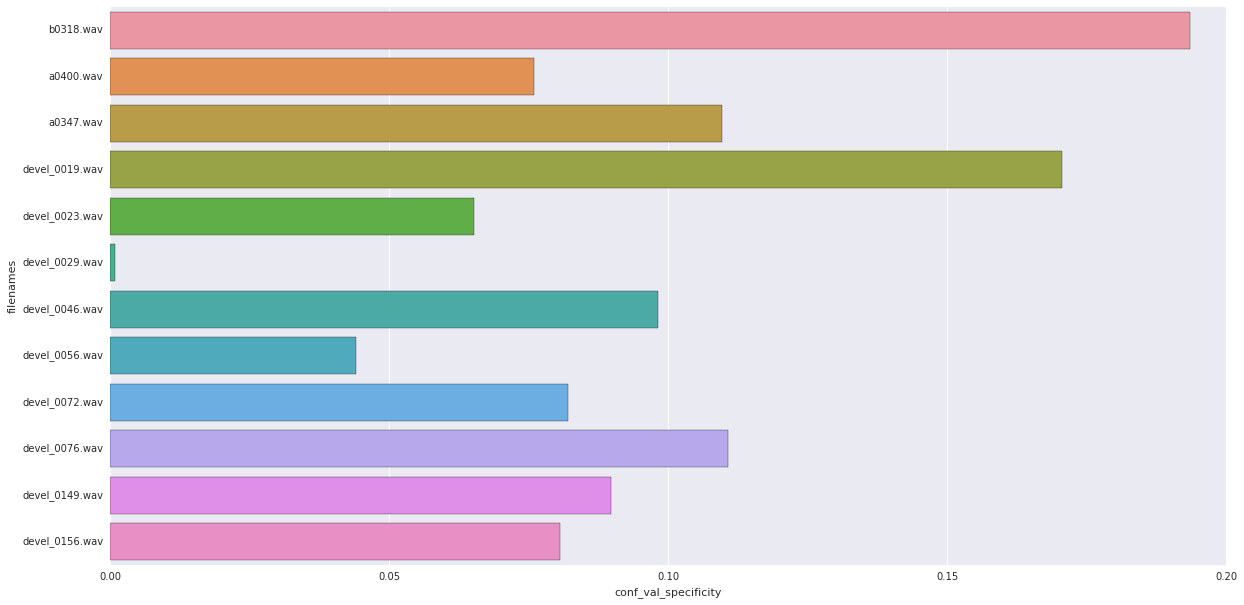

b0318.wav 1
a0400.wav 1
a0347.wav 1
devel_0019.wav 1
devel_0023.wav 1
devel_0029.wav 1
devel_0046.wav 1
devel_0056.wav 1
devel_0072.wav 1
devel_0076.wav 1
devel_0149.wav 0
devel_0156.wav 0


In [372]:
plt.figure(figsize=(20,10))
mask = dfVal['conf_'+metric]<=confidence_thresh
sns.barplot(x=dfVal['conf_'+metric][mask],y=dfVal.filenames[mask])
plt.show()
for names in zip(dfVal.filenames[mask],dfVal.true[mask]):
    print("%s %d" % names)

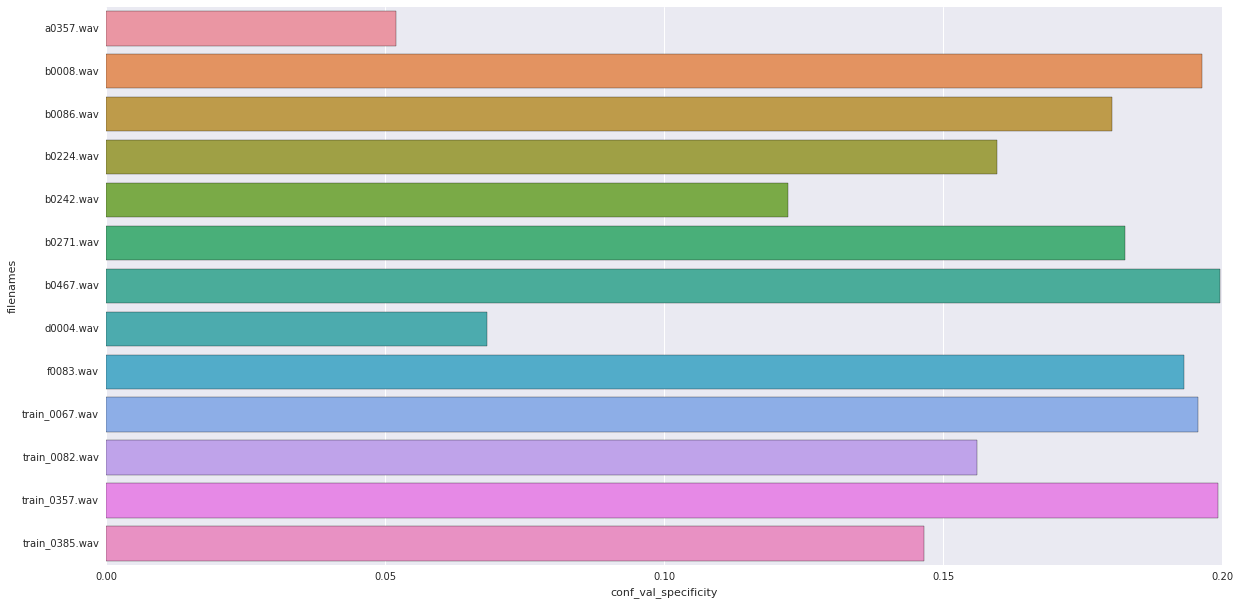

a0357.wav 1
b0008.wav 1
b0086.wav 1
b0224.wav 1
b0242.wav 1
b0271.wav 1
b0467.wav 1
d0004.wav 1
f0083.wav 1
train_0067.wav 1
train_0082.wav 1
train_0357.wav 1
train_0385.wav 1


In [373]:
plt.figure(figsize=(20,10))
mask = dfTrain['conf_'+metric]<=confidence_thresh
sns.barplot(x=dfTrain['conf_'+metric][mask],y=dfTrain.filenames[mask])
plt.show()
for names in zip(dfTrain.filenames[mask],dfTrain.true[mask]):
    print("%s %d" % names)

## Find out the recordings that have huge fluctuations in confidence

In [395]:
for epoch in range(min_epoch,df.epoch.count()):
    checkpoint_name = os.path.join(model_dir+log_name,
                                   "weights.%.4d-%.4f.hdf5" % (epoch+1,df.val_acc.iloc[epoch]))
    model.load_weights(checkpoint_name)
    y_pred = model.predict(x_train, verbose=1)
    y_pred_hard = np.argmax(y_pred,axis=-1)
    predicted_confidence = np.asarray([y_pred[i,j] for i,j in zip(range(len(y_pred)),np.nditer(y_train_cc))])
    start_idx=0
    pred = []
    for s in train_parts:
        if not s:  ## for e00032 in validation0 there was no cardiac cycle
            continue
        # ~ print "part {} start {} stop {}".format(s,star_idx,start_idx+int(s)-1)
        temp = sum(predicted_confidence[start_idx:start_idx + int(s) - 1])/s
        pred.append(temp)
        start_idx = start_idx + int(s)
    dfTrain["weights.%.4d-%.4f.hdf5" % (epoch+1,df.val_acc.iloc[epoch])]=pred

93942/93942 [==============================] - 12s 123us/step


In [436]:
list_sweep = dfTrain.columns[-(df.epoch.count()-min_epoch):] # list of columns for sweep
plt.figure(figsize=(20,10))
sns.boxplot(x="filenames",data=dfTrain[list_sweep.append("filenames")])
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


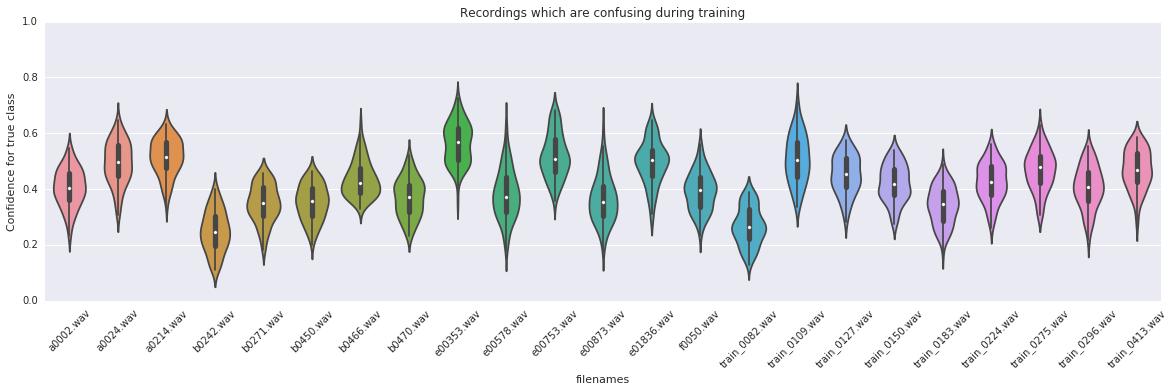

a0002.wav
a0024.wav
a0214.wav
b0242.wav
b0271.wav
b0450.wav
b0466.wav
b0470.wav
e00353.wav
e00578.wav
e00753.wav
e00873.wav
e01836.wav
f0050.wav
train_0082.wav
train_0109.wav
train_0127.wav
train_0150.wav
train_0183.wav
train_0224.wav
train_0275.wav
train_0296.wav
train_0413.wav


In [635]:
test = dfTrain[dfTrain.conf_var > ()][dfTrain.conf_val_macc < .5].transpose()
test = test.iloc[6:-2]
test.set_index(np.r_[0:test.count()[0]],inplace=True)
# list_sweep = test.columns.values
plt.figure(figsize=(20,5))
sns.violinplot(data=test,jitter=True)
plt.ylabel("Confidence for true class")
plt.title("Recordings which are confusing during training")
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.show()
for names in test.columns.values:
    print("%s" % names)

In [636]:
(.2**2)

0.04000000000000001

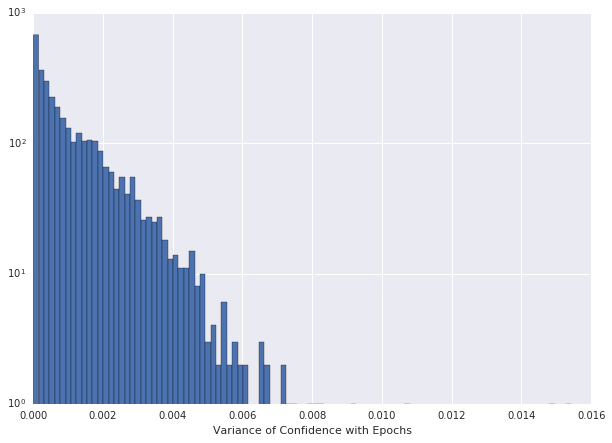

In [585]:
# dfTrain['conf_mean'] = dfTrain[list(dfTrain.columns.values)[-100:]].mean(axis=1).values
# dfTrain['conf_var'] = dfTrain[list(dfTrain.columns.values)[-100:]].var(axis=1).values
plt.figure(figsize=(10,7))
dfTrain.conf_var.hist(bins=100)
plt.xlabel("Variance of Confidence with Epochs")
plt.yscale('log')
plt.show()

In [605]:
list_= ["b0114.wav",
"b0226.wav",
"b0300.wav",
"d0001.wav",
"d0004.wav",
"d0015.wav",
"d0030.wav",
"d0037.wav",
"d0054.wav",
"train_0095.wav",
"train_0106.wav",
"train_0172.wav",
"train_0282.wav",
"train_0291.wav",
"train_0311.wav",
"train_0363.wav",
"train_0431.wav",
"train_0458.wav",
"train_0468.wav",
"train_0475.wav",
"train_0484.wav",
"train_0493.wav",
"a0118.wav",
"e00004.wav",
"e00017.wav",
"e00315.wav",
"e00578.wav",
"e00690.wav",
"e00720.wav",
"e00753.wav",
"e00873.wav",
"e00948.wav",
"e00954.wav",
"e01540.wav",
"e01887.wav",
"e02093.wav",
"f0021.wav",
"f0034.wav",
"f0058.wav",
"train_0109.wav"]

for name in list_:
    print(dfTrain['true'].loc[name])

0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0


In [ ]:
dfTrain.to_csv('/media/taufiq/Data1/heart_sound/dfTrain.csv',index=None)
dfVal.to_csv('/media/taufiq/Data1/heart_sound/dfVal.csv',index=None)